In [1]:
%load_ext autoreload
%autoreload 2

In [73]:
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../")
from src.utils import sample_points, sample_categories, sample_random_date_given_year_and_month

In [3]:
# specify paths to wildfire ignitions and forest type
path_to_ignition_points = r"C:\Users\David\Documents\ZGIS\Nextcloud_MyFiles\Projects\IGNITE\data\raw\BOKU_Fire_Ignitions\boku_wildfire_ignitions.shp"

path_to_forest_type_layer = r"C:\Users\David\Documents\ZGIS\Nextcloud_MyFiles\Projects\IGNITE\data\raw\BWF_forest_type\forest_type_merged.tif"

In [4]:
# read in wildfire ignition data
ignition_points = gpd.read_file(path_to_ignition_points)
ignition_points.head(2)

,WaldbrandI,Datum,UTC,Bundesland,WGS84_long,WGS84_lat_,Pufferradi,Ursache1,Near_build,N_people,Dist_roads,Roads,Rad_dist,aspect_aus,dhm_at_lam,slope_aust,Veg1,Veg2_1,Veg3_firEU,geometry
0,2021052701,5/27/2021,15:00,NOE,16.133164,47.877681,300,anthropogen,50.368667,7,54.166028,sonst,237.233615,326.15982,367.75150,11.21131,Pine_high_,Pine_high_,Urban,POINT (4779428.082 2770595.296)
1,2021052102,5/21/2021,7:50,NOE,16.181795,47.778698,50,anthropogen,207.367038,0,10.398109,for_road,8.045477,50.58361,303.09656,0.44824,Pine_high_,Pine_high_,Crop,POINT (4783946.969 2759929.697)


In [5]:
# print information of wildfire ignition dataset
#ignition_points.info()

In [6]:
# select human caused fires for training dataset creation
ignition_points_human = ignition_points[ignition_points["Ursache1"] == "anthropogen"]

# add label
ignition_points_human["fire"] = 1

# the reference system the data set should be transformed to
target_crs = "EPSG:31287"
ignition_points_human = ignition_points_human.to_crs(target_crs)

# create new columns containing month and year
ignition_points_human["year"] = ignition_points_human.Datum.apply(lambda x: x.split("/")[-1])
ignition_points_human["month"] = ignition_points_human.Datum.apply(lambda x: x.split("/")[0])

c:\Users\David\anaconda3\envs\pymc_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
# sample random points from Forest Type layer (non-ignition points) - as many as ignition points
nr_points = len(ignition_points_human)
non_ignition_points = sample_points(path_to_forest_type_layer, nr_points, random_seed=123)

In [8]:
# set crs to target crs (in theory old and target crs should be the same)
non_ignition_points = non_ignition_points.set_crs(target_crs, allow_override=True)

# create label
non_ignition_points["fire"] = 0

# fill column "Pufferadi" with Nones
non_ignition_points["Pufferradi"] = None

In [9]:
# calculate probability of fire ignition per month based on historic ignitions data
nr_ignitions_per_month = dict(ignition_points_human["month"].value_counts())
nr_ignitions_per_month = dict(sorted(nr_ignitions_per_month.items(), key=lambda x: int(x[0])))
probs_ignitions_per_month = [prob / len(ignition_points_human) for prob in list(nr_ignitions_per_month.values())]

In [10]:
# sample months values for non-fire ignitions based on probabilities of fire ignitions
months_numbers = [int(i) for i in list(nr_ignitions_per_month.keys())]
non_fire_ignition_month_samples = sample_categories(months_numbers, probs_ignitions_per_month, len(non_ignition_points), random_seed=123)
non_ignition_points["month"] = non_fire_ignition_month_samples
nr_non_ignitions_per_month = dict(non_ignition_points["month"].value_counts())

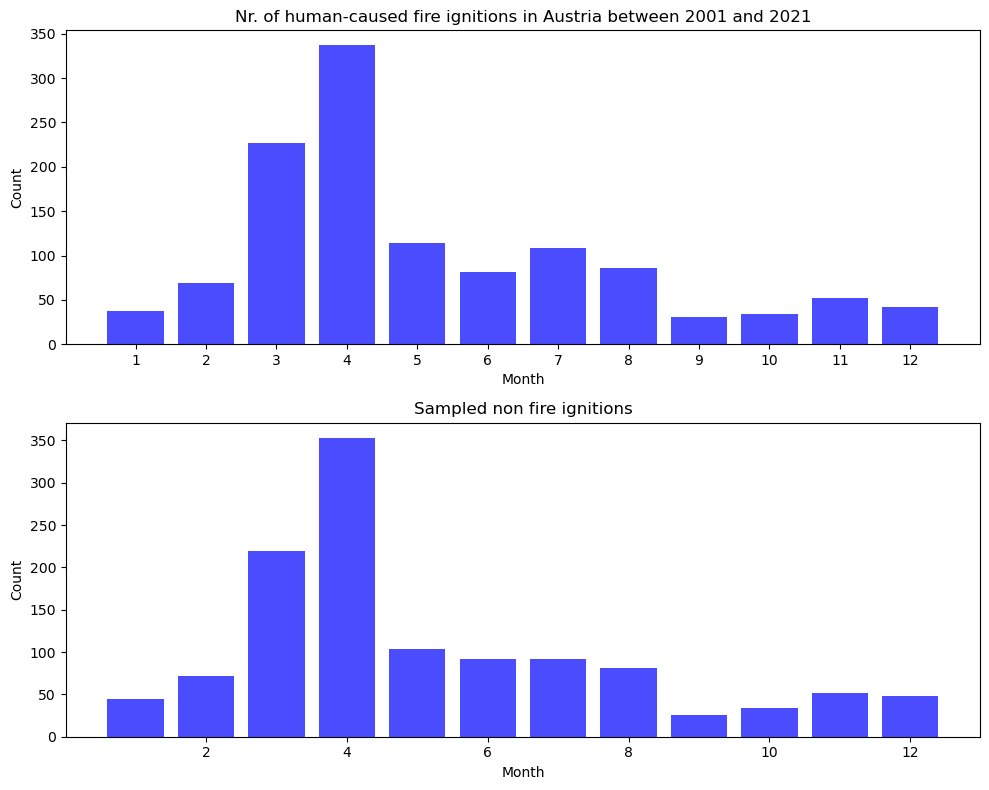

In [11]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting the first subplot
ax1.bar(nr_ignitions_per_month.keys(), nr_ignitions_per_month.values(), color='blue', alpha=0.7)
ax1.set_xlabel('Month')
ax1.set_ylabel('Count')
ax1.set_title("Nr. of human-caused fire ignitions in Austria between 2001 and 2021")

# Plotting the second subplot
ax2.bar(nr_non_ignitions_per_month.keys(), nr_non_ignitions_per_month.values(), color='blue', alpha=0.7)
ax2.set_xlabel('Month')
ax2.set_ylabel('Count')
ax2.set_title("Sampled non fire ignitions")

# Adjusting layout for better visualization
plt.tight_layout()

# Displaying the combined figure
plt.show()


In [88]:
# Randomly sample year and day for non-fire ignitions
non_fire_ignitions_year_samples = np.random.choice(range(2001, 2021), len(non_ignition_points))


In [89]:

dates = []
np.random.seed(123)
random_seeds = np.random.randint(0, 1000, len(non_fire_ignition_month_samples))
for month, year, random_seed in zip(non_fire_ignition_month_samples, non_fire_ignitions_year_samples, random_seeds):
    dates.append(sample_random_date_given_year_and_month(month, year, random_seed))

In [90]:
# create dates column and select relevant columns
non_ignition_points["date"] = dates
non_ignition_points_slim = non_ignition_points.loc[:, ["date", "Pufferradi", "fire", "geometry"]]

In [91]:
# choose relevant columns and rename Datum to date
ignition_points_human_slim = ignition_points_human.loc[:, ["Datum", "Pufferradi", "fire", "geometry"]]
ignition_points_human_slim.rename(columns={"Datum": "date"}, inplace=True)

In [92]:
# merge fire ignition and non-ignition points
fire_data_labels = pd.concat([ignition_points_human_slim, non_ignition_points_slim], ignore_index=True)

In [95]:
# create new columns containing month and year
fire_data_labels["year"] = fire_data_labels.date.apply(lambda x: x.split("/")[-1])
fire_data_labels["month"] = fire_data_labels.date.apply(lambda x: x.split("/")[0])
fire_data_labels["day"] = fire_data_labels.date.apply(lambda x: x.split("/")[1])

,date,Pufferradi,fire,geometry,year,month,day
0,5/27/2021,300,1,POINT (609377.781 445800.096),2021,5,27
1,5/21/2021,50,1,POINT (613414.750 434937.521),2021,5,21
2,5/21/2021,250,1,POINT (611564.181 433471.046),2021,5,21
3,5/11/2021,50,1,POINT (550216.159 397819.592),2021,5,11
4,5/11/2021,50,1,POINT (281489.140 390784.067),2021,5,11
...,...,...,...,...,...,...,...
2431,04/28/2010,None,0,POINT (627786.150 399077.650),2010,04,28
2432,11/10/2012,None,0,POINT (664097.458 531672.427),2012,11,10
2433,07/26/2016,None,0,POINT (547803.269 459959.843),2016,07,26
2434,03/28/2006,None,0,POINT (447159.643 468090.136),2006,03,28


In [98]:
path_to_output =r"C:\Users\David\Documents\ZGIS\Nextcloud_MyFiles\Projects\IGNITE\data\processed\fire_data\fire_data.shp"
fire_data_labels.to_file(path_to_output)

In [99]:
fire_data_labels

,date,Pufferradi,fire,geometry,year,month,day
0,5/27/2021,300,1,POINT (609377.781 445800.096),2021,5,27
1,5/21/2021,50,1,POINT (613414.750 434937.521),2021,5,21
2,5/21/2021,250,1,POINT (611564.181 433471.046),2021,5,21
3,5/11/2021,50,1,POINT (550216.159 397819.592),2021,5,11
4,5/11/2021,50,1,POINT (281489.140 390784.067),2021,5,11
...,...,...,...,...,...,...,...
2431,04/28/2010,None,0,POINT (627786.150 399077.650),2010,04,28
2432,11/10/2012,None,0,POINT (664097.458 531672.427),2012,11,10
2433,07/26/2016,None,0,POINT (547803.269 459959.843),2016,07,26
2434,03/28/2006,None,0,POINT (447159.643 468090.136),2006,03,28
